In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import datetime

import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

#from models.multilevel_layers import MultilevelDense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from functools import reduce
import ipdb

import collections


tfd = tfp.distributions

In [2]:
%load_ext tensorboard

# Single parameter

## Data generation

In [3]:
def data_generator(gid):
    #x_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    gid_tf = tf.cast(tf.convert_to_tensor(gid), tf.int32)
    num_groups = tf.cast(tf.convert_to_tensor(max(gid) + 1), tf.int32)
    """Creates a joint distribution for the varying slope model."""
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=1., scale=0.1, name='w_z_0'),
#         tfd.Independent(
#             tfd.HalfCauchy(loc=tf.ones([num_groups])*0.1, scale=0.01, name='w_lambda_k'),
#             reinterpreted_batch_ndims=1),
        tfd.HalfCauchy(loc=1, scale=0.01, name='w_lambda_k'),

        lambda w_lambda_k, w_z_0: tfd.Independent(tfd.Normal( 
            loc=tf.ones([num_groups])*w_z_0,
            scale=w_lambda_k,
            name='w_z_k'), reinterpreted_batch_ndims=1),

        lambda w_z_k: tfd.MultivariateNormalDiag(  # y
            loc=tf.gather(w_z_k, gid_tf, axis=-1) ,
            scale_identity_multiplier=0.5,
            name='x')
   ])

In [4]:
ng=20
avg_samp = 20
np.random.seed(3229)
gi = np.random.choice(ng, size=[ng*avg_samp])

print(collections.Counter(gi))

gen_process = data_generator(gi)
tf.random.set_seed(1)
gen = gen_process.sample(seed=7)

xi=gen[-1].numpy()
print(gen[:-1])

Counter({14: 27, 15: 27, 7: 24, 6: 23, 13: 23, 18: 22, 10: 22, 19: 21, 5: 20, 1: 20, 8: 20, 3: 19, 12: 19, 9: 18, 16: 18, 17: 18, 11: 17, 2: 15, 4: 15, 0: 12})
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9242421>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0104575>, <tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 1.5396011 ,  0.8021826 ,  1.1984613 ,  1.0655437 , -0.22674459,
       -0.15848154,  0.73196423,  0.39405507,  0.500525  ,  0.91956156,
        2.0734231 ,  0.6850368 ,  0.97898316, -0.05928135,  1.8084259 ,
       -0.21522802,  1.7886177 ,  0.9028492 , -0.22068304,  0.9235853 ],
      dtype=float32)>]


In [5]:
yi = 2.*xi + 1. + np.random.randn(len(xi))/5

In [6]:
x_train, x_test, y_train, y_test,  gid_train, gid_test = train_test_split(
    xi, yi, gi, stratify=gi, random_state=9022, test_size=0.9)
tts = [x_train, x_test, y_train, y_test, gid_train, gid_test]

x_train = tf.convert_to_tensor(x_train)[...,tf.newaxis]
x_test = tf.convert_to_tensor(x_test)[...,tf.newaxis]
y_train = tf.convert_to_tensor(y_train)[...,tf.newaxis]
y_test = tf.convert_to_tensor(y_test)[...,tf.newaxis]
gid_train = tf.cast(tf.convert_to_tensor(gid_train), tf.int32)
gid_test = tf.cast(tf.convert_to_tensor(gid_test), tf.int32)

## Baseline model

In [7]:
def mean_estimator_error(train, test):
    return np.abs(np.mean(train) - np.mean(test))
    

In [8]:
check_tensor = lambda x: isinstance(x, tf.python.framework.ops.EagerTensor)

In [9]:
def get_segments(data, gid, idx): 
    if check_tensor(data):
        data = data.numpy()
    if check_tensor(gid):
        gid = gid.numpy()
    return data[np.where(gid == idx)[0]]

In [10]:
print('Baseline estimator:', mean_estimator_error(x_train, x_test))

Baseline estimator: 0.06372517


In [11]:
for i in range(ng):
    train = get_segments(x_train, gid_train, i)
    test = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train, test))

Baseline estimator per group: 0.29663312
Baseline estimator per group: 0.6617641
Baseline estimator per group: 0.10195196
Baseline estimator per group: 0.27956998
Baseline estimator per group: 0.34731218
Baseline estimator per group: 0.05775149
Baseline estimator per group: 0.08168769
Baseline estimator per group: 0.87159
Baseline estimator per group: 0.010310769
Baseline estimator per group: 0.23998612
Baseline estimator per group: 0.496706
Baseline estimator per group: 0.31026387
Baseline estimator per group: 0.6093107
Baseline estimator per group: 0.31341195
Baseline estimator per group: 0.039975286
Baseline estimator per group: 0.1481406
Baseline estimator per group: 0.32705867
Baseline estimator per group: 0.12343633
Baseline estimator per group: 0.31735182
Baseline estimator per group: 0.026184022


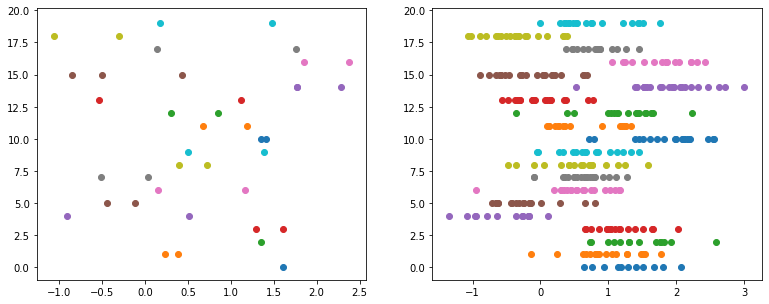

In [12]:
fig, axes =plt.subplots(1,2, figsize=(13,5))
for i in range(ng):
    
    axes[0].scatter(get_segments(x_train, gid_train, i), [i]*len(get_segments(x_train, gid_train, i)))

    axes[1].scatter(get_segments(x_test, gid_test, i), [i]*len(get_segments(x_test, gid_test, i)))

In [13]:
gen[2]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 1.5396011 ,  0.8021826 ,  1.1984613 ,  1.0655437 , -0.22674459,
       -0.15848154,  0.73196423,  0.39405507,  0.500525  ,  0.91956156,
        2.0734231 ,  0.6850368 ,  0.97898316, -0.05928135,  1.8084259 ,
       -0.21522802,  1.7886177 ,  0.9028492 , -0.22068304,  0.9235853 ],
      dtype=float32)>

## Model classes

In [15]:
@tf.function
def tf_gather(x, ind):
    return tf.gather(x + 0, ind)

In [16]:
# group_kl_weights should be [k1, k2, k3] / train_size

In [17]:
var = HierarchicalVariableLayer([1,], 3, 1.)

In [18]:
var.build(None)

In [19]:
var.call(tf.convert_to_tensor([0]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.06573077]], dtype=float32)>

In [20]:
var.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=8.114257>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.15608111>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.032853>]

## Test KL and log prob terms

In [1820]:
# KL terms
tfd.kl_divergence(tfd.Normal(0., tf.nn.softplus(-4.)), tfd.Normal(0. , 100.))

<tf.Tensor: shape=(), dtype=float32, numpy=8.114258>

In [1013]:
# KL terms
tfd.kl_divergence(tfd.Normal([-1.,  -1., -1.], tf.math.exp(-2.)), tfd.Normal(0. , 1.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.009158, 2.009158, 2.009158], dtype=float32)>

In [1014]:
# KL terms
tfd.kl_divergence(tfd.Normal([-1.,  2., 2.], tf.nn.softplus(1.)), tfd.Normal(0. , 1.))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5898142, 2.0898142, 2.0898142], dtype=float32)>

In [1015]:
def z_k_kl_loss_fn():
#     z = tf.reduce_mean(
#         tfd.Normal(tf.convert_to_tensor([1., -1., 1.]), 
#                    tf.convert_to_tensor([0.1, 0.1, 0.1]))
#         .sample(100), axis=0)
    mu0 = tf.reduce_mean(tfd.Normal(1., tf.nn.softplus(-2.)).sample(100), axis=0)
    z = tf.reduce_mean(
        tfd.Normal(
            tf.convert_to_tensor([1.]), 
            tf.convert_to_tensor([2.]))
        .sample(100), axis=0)
    print(mu0)
    print(z)
    return -1 * tfd.Normal(mu0, 1).log_prob(z)

In [1016]:
z_k_kl_loss_fn()

tf.Tensor(0.99928784, shape=(), dtype=float32)
tf.Tensor([1.1110892], shape=(1,), dtype=float32)


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9251883], dtype=float32)>

In [1017]:
tfd.Normal(1, 0.0001).log_prob([1])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.291402], dtype=float32)>

In [1018]:
muk = tf.convert_to_tensor(np.ones([3,4])*10.)
mu0 = tf.convert_to_tensor(np.ones([4])*12.)

(tf.einsum('kd, kd  -> k', muk, muk) 
 + tf.einsum('d,d -> ', mu0, mu0)
            - 2 * tf.einsum('kd,d -> k', muk, mu0))

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([16., 16., 16.])>

In [284]:
def z_k_kl_loss_fn():
    #sigma_k_pos = var_activation(self.sigma_k)
    #tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))        
#     sigma_k_pos = tf.convert_to_tensor([0.1, 0.1, 0.1])
    sigma_k_pos = tf.convert_to_tensor([tf.nn.softplus(-4.)])
    tau_k_sq = tf.convert_to_tensor([1.05])
    sigma0_pos = tf.convert_to_tensor([tf.nn.softplus(-4.)])
    #mu_k = tf.convert_to_tensor([1., -1., 1.])
    mu_k = tf.convert_to_tensor([-0.058])
    mu0 = tf.convert_to_tensor(0.)
    #z0 = self.sample_posterior(self.mu0, var_activation(self.sigma0))

#     print(tf.reduce_sum(sigma_k_pos, axis=[-1]) 
#             , tf.reduce_sum(sigma0_pos, axis=[-1]) ,
#         tf.einsum('i, i  -> i', mu_k, mu_k)
#             , tf.einsum(', -> ', mu0, mu0)
#             ,- 2 * tf.einsum('i, -> i', mu_k, mu0))
    d = 1
    z_k_log_prob = (
        - 1/2 * d * np.log(2*np.pi) 
        - 1/2 * d * tf.math.log(tau_k_sq)
        - 1/2/tau_k_sq * (
            tf.reduce_sum(sigma_k_pos, axis=[-1]) 
            + tf.reduce_sum(sigma0_pos, axis=[-1]) 
            + tf.einsum('i, i  -> i', mu_k, mu_k)
            + tf.einsum(', -> ', mu0, mu0)
            - 2 * tf.einsum('i, -> i', mu_k, mu0)))

    return -1* z_k_log_prob
    #return -1 * tf.multiply(1, tf.reduce_sum(z_k_log_prob))

In [285]:
z_k_kl_loss_fn()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.96222115], dtype=float32)>

In [1023]:
def z_k_kl_loss_fn(): 
    #tau_k = self.sample_posterior(self.tau_k_mu, var_activation(self.tau_k_sigma))  
    #tau_k = tfd.Normal([-1,2,2], 0.1).sample()
    #tau_k_sq = tau_k ** 2 
    tau_k_sq = 1
    z0 = tfd.Normal(1., tf.nn.softplus(0.1)).sample()
    z0 = 0.
    print(z0, tau_k_sq)
    return tfd.kl_divergence(tfd.Normal([-1.,1.,1.], tf.nn.softplus(-2.)), tfd.Normal(z0, tau_k_sq))
    


In [1024]:
z_k_kl_loss_fn()

0.0 1


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.0721903, 2.0721903, 2.0721903], dtype=float32)>

## Training

In [409]:
def train(x, y, model, loss_fn, optimizer, batch_size, epochs, log_file, kl_annealing, print_freq=1, verbose=False):
    if isinstance(x, list):
        train_size = len(x[0])
    else:
        train_size = len(x)
    num_batches = int(np.ceil(train_size/batch_size))
    train_summary_writer = tf.summary.create_file_writer(log_file)
    
    for epoch in range(epochs):
        
        for step in range(num_batches):
            global_step = epoch*num_batches + step
            start, end = batch_size*step, batch_size*(step+1)
            # e.g. x = [xt, gid]
            if isinstance(x, list):
                xb = [xi[start:end] for xi in x]
            else:
                xb = x[start:end]
            yb = y[start:end]
            
            
            if kl_annealing:
                kl_annealing_weight = tf.convert_to_tensor(min(1., (global_step/num_batches) / (epochs/2)))
            else: 
                kl_annealing_weight = 1.
            loss_dict, grad_dict = train_step(xb, yb, model, loss_fn, optimizer, kl_annealing_weight)
            
            #[loss, z0_kl_loss, tau_k_kl_loss, z_k_log_prob_loss] = losses
            #[loss_grads, z0_kl_loss_grads, tau_k_kl_loss_grads, z_k_log_prob_loss_grads, total_loss_grads] = grads
            
            if epoch % print_freq == 0 and step+1 == num_batches:
                if verbose:
                    print('VARIABLES FOR GROUP')
                    (mu_k, sigma_k, mu0, sigma0, tau_k_mu, tau_k_sigma, z0_prior_mean, 
                     z0_prior_variance, tau_k_prior_mean, tau_k_prior_variance) = model.get_weights()

                    for w in model.variables:
                        wg = w
                        wg = np.squeeze(wg.numpy())
                        # vector
                        if len(wg.shape) >= 1:

                            print('{:<70}{}'.format(w.name, wg))
                        else:
                            # scalar
                            print('{:<70}{:<+.5}'.format(w.name, wg))
                    print('\n')

                    print('KL LOSSES (scaled by {:.4})'.format(model.kl_weight))
                    print('NOTE: scaling by ', num_batches)
                    for name, kl in {'z0_kl_loss':  z0_kl_loss, 
                                     'tau_k_kl_loss':  tau_k_kl_loss, 
                                     'z_k_log_prob_loss':  z_k_log_prob_loss}.items():
                        print('{:<15} = {:<10.3}'.format(name, kl.numpy()))
                    print('\n')

                    print('GID, PRED, TRUE, LOSS')
                    for i in range(len(pred)):
                        print('{:<30}{:<+10.3}{:<+10.3}{:<5.3}'.format(
                            xb[i], 
                            pred[i].numpy()[0], 
                            yb[i].numpy()[0], 
                            loss_fn(pred[i], yb[i])))
                    print('LOSS: ',loss.numpy())
                    print('\n')

                    print('GRADS')
                    for i, var in enumerate(model.trainable_variables):

                        def safe_grad_i(grad):
                            if grad[i] is not None:
                                print(grad[i].numpy())
                            else:
                                print(grad[i])

                        print(var.name)
                        print('LOSS GRADS')
                        safe_grad_i(loss_grads)
                        print('z0 KL GRADS')
                        safe_grad_i(z0_kl_loss_grads)
                        print('tau k KL GRADS')
                        safe_grad_i(tau_k_kl_loss_grads)
                        print('z k log prob GRADS')
                        safe_grad_i(z_k_log_prob_loss_grads)
                        print('TOTAL GRADS')
                        safe_grad_i(total_loss_grads)
                        print('\n')
                    print('\n====================')
                else:
                    #print('Loss = {:<+10.2} z0_kl_loss = {:<+10.2} tau_k_kl_loss = {:<+10.2} z_k_log_prob_loss = {:<+10.2}'.format(
                    #    loss, z0_kl_loss, tau_k_kl_loss, z_k_log_prob_loss))
                    print(loss_dict['loss'], loss_dict['total_loss'])
 
            
                #import ipdb; ipdb.set_trace()

                names = [model.name + "/" + layer.name +"/" + weight.name for layer in model.layers for weight in layer.trainable_weights]

                with train_summary_writer.as_default():

                    for loss_name, loss_val in loss_dict.items():
                         tf.summary.scalar(loss_name, loss_val, step=global_step)

                    for i, weight in enumerate(model.trainable_weights):

                        tf.summary.histogram(names[i]+'/weight', weight, step=global_step)

                        def safe_grad_tb(grad, grad_name):
                            # Decided I only want to log non-zero grads
                            if grad is not None:
                                tf.summary.histogram(grad_name, grad, step=global_step)
                            # Just return zero if grads are None
                            #grad = tf.zeros_like(weights[i])

                        #print(name, weights[i].name, weights[i], loss_grads[i], z_k_log_prob_loss_grads[i])

                        for grad_name, grad_val in grad_dict.items():
                            safe_grad_tb(grad_val, grad_name)

    #                     safe_grad_tb(loss_grads[i], 'loss_grads')
    #                     safe_grad_tb(z0_kl_loss_grads[i], 'z0_kl_loss_grads')
    #                     safe_grad_tb(tau_k_kl_loss_grads[i], 'tau_k_kl_loss_grads')
    #                     safe_grad_tb(z_k_log_prob_loss_grads[i], 'z_k_log_prob_loss_grads')
                    
                    
            #do hist of losses across layers

@tf.function            
def train_step(xb, yb, model, loss_fn, optimizer, kl_annealing_weight):
    # Needed so that I can call tape.gradient multiple times
    with tf.GradientTape(persistent=True) as tape:

        pred = model(xb)
        loss = loss_fn(yb, pred)
        
        #z0_kl_loss, tau_k_kl_loss, z_k_log_prob_loss = model.losses
        #total_loss = loss + kl_annealing_weight * (z0_kl_loss + tau_k_kl_loss + z_k_log_prob_loss)
        
       
    
        grads_dict = {}
        loss_dict = {}
#         #non_hier_losses = []
#         for layer in model.layers:
#             # hierarchical
#             if layer.losses:
#                 try:
#                     if layer.multilevel_weights and layer.multilevel_bias:
#                         (w_z0_kl_loss, w_tau_k_kl_loss, w_z_k_log_prob_loss, 
#                          b_z0_kl_loss, b_tau_k_kl_loss, b_z_k_log_prob_loss) = layer.losses

#                         loss_names = [model.name+'/'+layer.name+'/'+loss_name for loss_name in 
#                                  ['w_z0_kl_loss', 'w_tau_k_kl_loss', 'w_z_k_log_prob_loss', 
#                                   'b_z0_kl_loss', 'b_tau_k_kl_loss', 'b_z_k_log_prob_loss']]

#                         loss_dict = {**loss_dict, **{
#                             loss_names[0]: w_z0_kl_loss, 
#                             loss_names[1]: w_tau_k_kl_loss, 
#                             loss_names[2]: w_z_k_log_prob_loss, 
#                             loss_names[3]: b_z0_kl_loss, 
#                             loss_names[4]: b_tau_k_kl_loss, 
#                             loss_names[5]: b_z_k_log_prob_loss}}
#                     else:
#                         print('NOT IMPLEMENTED')
#                         raise NotImplementedError()


#                 except:
#                     print('Not tracking these losses in tensorboard')
#                     raise NotImplementedError()
#                     #non_hier_losses.append(layer.losses)
                    
#         kl_losses = [
#             loss_val 
#             for loss_key, loss_val 
#             in loss_dict.items()
#             if ('kl_loss' in loss_key) or ('log_prob_loss' in loss_key)]
        
#         total_loss = loss + kl_annealing_weight * sum(kl_losses)
        total_loss = loss + kl_annealing_weight * sum(model.losses)
          
#     # Add loss and total loss to dict so that they show up in TB, put above the for loop or else
#     # won't get total loss grads for every var
    loss_dict['loss'] = loss
    loss_dict['total_loss'] = total_loss
#     # kl_loss: [list of grads for each var]
    
#     names = [model.name + "/" + layer.name +"/" + weight.name for layer in model.layers for weight in layer.trainable_weights]
    
#     for loss_key, loss_val in loss_dict.items():
#         loss_name = re.search('/?([ a-zA-Z\-\:0-9\_]*)$', loss_key).group(1)

#         for i, weight in enumerate(model.trainable_weights):
#             grads_dict[names[i]+'/'+loss_name+'/'+'grad'] = tape.gradient(loss_val, weight)
        
   
    #print(model.losses)
  
    total_loss_grads = tape.gradient(total_loss, model.trainable_weights)
#     loss_grads = []
#     z0_kl_loss_grads = []
#     tau_k_kl_loss_grads = []
#     z_k_log_prob_loss_grads = []
#     total_loss_grads = []
#     for weight in model.trainable_weights:
#         loss_grads              += [tape.gradient(loss, weight)]
#         z0_kl_loss_grads        += [tape.gradient(z0_kl_loss, weight)]
#         tau_k_kl_loss_grads     += [tape.gradient(tau_k_kl_loss, weight)]
#         z_k_log_prob_loss_grads += [tape.gradient(z_k_log_prob_loss, weight)]
#         total_loss_grads        += [tape.gradient(total_loss, weight)]

    optimizer.apply_gradients(zip(total_loss_grads, model.trainable_weights))
    del tape
    
    #return (
    #    [loss, z0_kl_loss, tau_k_kl_loss, z_k_log_prob_loss], 
    #    [loss_grads, z0_kl_loss_grads, tau_k_kl_loss_grads, z_k_log_prob_loss_grads, total_loss_grads])
    return loss_dict, grads_dict
    

In [268]:
import re


In [224]:
model.trainable_variables

[<tf.Variable 'kernel/mu_k:0' shape=(20, 1) dtype=float32, numpy=
 array([[ 0.05021843],
        [-0.0641843 ],
        [ 0.00453139],
        [-0.01994194],
        [ 0.04216685],
        [ 0.00260519],
        [-0.05466994],
        [-0.02628108],
        [ 0.09117123],
        [ 0.10458584],
        [ 0.04092994],
        [ 0.08738621],
        [ 0.01955723],
        [-0.05366224],
        [ 0.23485689],
        [ 0.07532229],
        [-0.05454368],
        [-0.08108396],
        [ 0.05369604],
        [ 0.1452418 ]], dtype=float32)>,
 <tf.Variable 'kernel/sigma_k:0' shape=(20, 1) dtype=float32, numpy=
 array([[-4.0002995],
        [-4.00032  ],
        [-4.000031 ],
        [-4.000265 ],
        [-4.0002503],
        [-4.0002594],
        [-4.000719 ],
        [-4.0002866],
        [-4.000257 ],
        [-4.00051  ],
        [-4.0005393],
        [-4.0000663],
        [-4.000345 ],
        [-4.000182 ],
        [-3.9987822],
        [-4.000079 ],
        [-3.9990706],
        [-4.0

In [227]:
[x.name for x in model.trainable_weights]

['kernel/mu_k:0',
 'kernel/sigma_k:0',
 'kernel/mu0:0',
 'kernel/sigma0:0',
 'kernel/tau_k_mu:0',
 'kernel/tau_k_sigma:0',
 'bias/mu_k:0',
 'bias/sigma_k:0',
 'bias/mu0:0',
 'bias/sigma0:0',
 'bias/tau_k_mu:0',
 'bias/tau_k_sigma:0',
 'kernel/mu_k:0',
 'kernel/sigma_k:0',
 'kernel/mu0:0',
 'kernel/sigma0:0',
 'kernel/tau_k_mu:0',
 'kernel/tau_k_sigma:0',
 'bias/mu_k:0',
 'bias/sigma_k:0',
 'bias/mu0:0',
 'bias/sigma0:0',
 'bias/tau_k_mu:0',
 'bias/tau_k_sigma:0']

In [15]:
# model.call(gid_train)
# # model.losses

In [16]:
batch_size=40
num_batches = np.ceil(len(x_train) / batch_size)
#count_dict = collections.Counter(gid_train.numpy())
#group_train_sizes = np.array([count_dict[i] for i in range(ng)])
# I think this is actually not correct
#group_kl_weights = group_train_sizes / num_batches

In [410]:
from models.multilevel_layers import MultilevelDense, MyDense, TFPMultilevelDense, MyMultilevelDense, TFPDense
from models.multilevel_variables import HierarchicalVariableLayer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [411]:
class MyModel(tf.keras.Model):

    def __init__(self,num_groups, kl_weight, *args, **kwargs):
        super(MyModel, self).__init__(*args, **kwargs)

        self.num_groups = num_groups
        self.kl_weight = kl_weight
        self.x_hier = HierarchicalVariableLayer(
            variable_shape=[1], 
            num_groups=num_groups,
        kl_weight=kl_weight)

    @tf.function
    def call(self, gid):
        out = self.x_hier(gid)
        return out

In [413]:
loss_fn = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [239]:
model = MyModel(
    num_groups=tf.convert_to_tensor(ng),
    kl_weight=tf.convert_to_tensor(1/num_batches, dtype=tf.float32))

In [240]:
model.layers[0].losses

[]

In [241]:
model.losses

[]

In [242]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir='../experiments/parameter_est/' + current_time
train(gid_train, x_train, model, loss_fn, optimizer, batch_size, epochs=400, log_file=log_dir, print_freq=40, verbose=False)

TypeError: train() missing 1 required positional argument: 'kl_annealing'

In [ ]:
model.get_weights()

In [840]:
# mse = tf.keras.losses.MeanSquaredError(
#     reduction=tf.keras.losses.Reduction.SUM)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
#     loss=mse,
#     metrics=['mse'])

In [539]:
# import datetime
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model.fit(x=gid_train, 
#           y=x_train, 
#           batch_size=batch_size, 
#           epochs=100, 
#           #verbose=False,
#           callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../experiments/parameter_est/' + current_time, 
#                                                     profile_batch='5',
#                                                     histogram_freq=10)])

Epoch 1/100
1/1 [==============================] - 0s 6ms/step - loss: 36.8087 - mse: 0.2208
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 34.9425 - mse: 0.2704
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 36.6155 - mse: 0.2947
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 37.6814 - mse: 0.3016
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 37.7255 - mse: 0.2958
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 37.4542 - mse: 0.2971
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 35.8812 - mse: 0.2884
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 33.2825 - mse: 0.2724
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 31.0849 - mse: 0.2658
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 30.5241 - mse: 0.2598
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - los

In [540]:
#--host localhost

## Results

In [300]:
%tensorboard --logdir=../experiments/reg/ --host localhost

In [112]:
def hierarchical_estimator_error(pred, test):
    return np.abs(pred - np.mean(test))

In [126]:
#def results():
diffs = []
for i in range(ng):
    train_ = get_segments(x_train, gid_train, i)
    test_ = get_segments(x_test, gid_test, i)
    print('Baseline estimator per group:', mean_estimator_error(train_, test_))
    print('Hierarchical estimator per group:', hierarchical_estimator_error(
        model.get_weights()[0][i,0], test_))
    
    diffs.append(mean_estimator_error(train_, test_) - hierarchical_estimator_error(
        model.get_weights()[0][i,0], test_))
print(np.sum(diffs), np.mean(np.abs(diffs)))
#results()

Baseline estimator per group: 0.29663312
Hierarchical estimator per group: 0.025268435
Baseline estimator per group: 0.6617641
Hierarchical estimator per group: 0.6204231
Baseline estimator per group: 0.10195196
Hierarchical estimator per group: 0.34494805
Baseline estimator per group: 0.27956998
Hierarchical estimator per group: 0.13821113
Baseline estimator per group: 0.34731218
Hierarchical estimator per group: 0.48740125
Baseline estimator per group: 0.05775149
Hierarchical estimator per group: 0.103073485
Baseline estimator per group: 0.08168769
Hierarchical estimator per group: 0.082175136
Baseline estimator per group: 0.87159
Hierarchical estimator per group: 0.76381826
Baseline estimator per group: 0.010310769
Hierarchical estimator per group: 0.010443628
Baseline estimator per group: 0.23998612
Hierarchical estimator per group: 0.21066427
Baseline estimator per group: 0.496706
Hierarchical estimator per group: 0.63000953
Baseline estimator per group: 0.31026387
Hierarchical es

In [114]:
model.get_weights()

[array([[ 1.2882653 ],
        [ 0.3490622 ],
        [ 1.110391  ],
        [ 1.3075151 ],
        [-0.0568198 ],
        [-0.11937688],
        [ 0.65597844],
        [-0.12673739],
        [ 0.56109446],
        [ 0.91523385],
        [ 1.2472957 ],
        [ 0.8837938 ],
        [ 0.5632851 ],
        [ 0.3530428 ],
        [ 1.7981135 ],
        [-0.18521176],
        [ 1.8699464 ],
        [ 0.8967029 ],
        [-0.46931848],
        [ 0.81488746]], dtype=float32), array([[-3.995164 ],
        [-4.0083036],
        [-3.9980886],
        [-3.981401 ],
        [-3.97807  ],
        [-4.002018 ],
        [-3.9552343],
        [-4.000118 ],
        [-4.015534 ],
        [-4.0352   ],
        [-3.9772925],
        [-3.9988842],
        [-3.983082 ],
        [-3.9595332],
        [-4.037818 ],
        [-4.01772  ],
        [-3.975266 ],
        [-4.086849 ],
        [-4.0236735],
        [-3.962448 ]], dtype=float32), array([0.6795855], dtype=float32), array([-3.278553], dtype=float32

In [115]:
for i in range(ng):
    print(np.mean(get_segments(x_train, gid_train, i)))

1.6101669
0.3077212
1.3533871
1.448874
-0.19690886
-0.28020185
0.655491
-0.23450918
0.5609616
0.9445557
1.3805993
0.9344974
0.57294387
0.29342037
1.9392673
-0.30614766
2.114462
0.94963217
-0.6814287
0.8277379


In [116]:
np.mean([np.mean(get_segments(x_train, gid_train, i)) for i in range(ng)])

0.70972604

In [117]:
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9242421>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0104575>,
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([ 1.5396011 ,  0.8021826 ,  1.1984613 ,  1.0655437 , -0.22674459,
        -0.15848154,  0.73196423,  0.39405507,  0.500525  ,  0.91956156,
         2.0734231 ,  0.6850368 ,  0.97898316, -0.05928135,  1.8084259 ,
        -0.21522802,  1.7886177 ,  0.9028492 , -0.22068304,  0.9235853 ],
       dtype=float32)>]

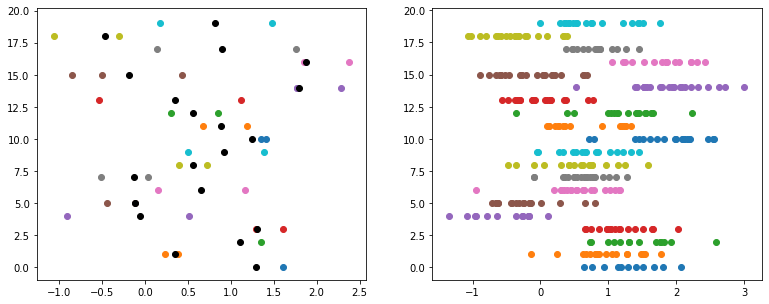

In [118]:
fig, axes =plt.subplots(1,2, figsize=(13,5))
for i in range(ng):
    
    axes[0].scatter(get_segments(x_train, gid_train, i), [i]*len(get_segments(x_train, gid_train, i)))
    axes[0].scatter(model.get_weights()[0][i,0], i, c='black')
    axes[1].scatter(get_segments(x_test, gid_test, i), [i]*len(get_segments(x_test, gid_test, i)))
    

# Regression

## Test layer

In [1280]:
ml_dense = MyMultilevelDense(2, 5)
ml_dense.build([[3,4], [3]])

[[3, 4], [3]]
2 4


In [1281]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
ml_dense([tf.zeros([3,4], dtype=np.float32), tf.convert_to_tensor([1,1,3])])

CPU times: user 240 ms, sys: 4.89 ms, total: 245 ms
Wall time: 249 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.07045714, 0.01027124],
       [0.07348996, 0.00551677],
       [0.0430214 , 0.02689526]], dtype=float32)>

In [1282]:
for w in ml_dense.trainable_weights:
    print('{:50}{}'.format(w.name, w.shape))

kernel/mu_k:0                                     (5, 8)
kernel/sigma_k:0                                  (5, 8)
kernel/mu0:0                                      (8,)
kernel/sigma0:0                                   (8,)
kernel/tau_k_mu:0                                 (8,)
kernel/tau_k_sigma:0                              (8,)
bias/mu_k:0                                       (5, 2)
bias/sigma_k:0                                    (5, 2)
bias/mu0:0                                        (2,)
bias/sigma0:0                                     (2,)
bias/tau_k_mu:0                                   (2,)
bias/tau_k_sigma:0                                (2,)


In [1283]:
ml_dense.w.mu_k

<tf.Variable 'kernel/mu_k:0' shape=(5, 8) dtype=float32, numpy=
array([[-0.08792584, -0.04422325,  0.00452912,  0.00027618, -0.05009226,
         0.03459109, -0.01713903,  0.01372507],
       [-0.0639912 , -0.05377474, -0.06974076, -0.00825747, -0.06106396,
        -0.01943289, -0.00815277,  0.02065617],
       [-0.06040412,  0.02254078,  0.10571667,  0.00901332,  0.0649086 ,
         0.01182872,  0.037123  ,  0.07362203],
       [ 0.03500663,  0.03235925,  0.04305859,  0.01620757,  0.0632214 ,
         0.02054363, -0.04169431,  0.03894564],
       [-0.05462474, -0.04887303,  0.04519743,  0.05429388,  0.06763227,
         0.01567664, -0.08993569,  0.02938987]], dtype=float32)>

In [1284]:
ml_dense = MyMultilevelDense(1, 10)
ml_dense.build([[90,1], [90]])

[[90, 1], [90]]
1 1


In [1285]:
%%time
#ml_dense([tf.zeros([3], dtype=np.float32), tf.convert_to_tensor([1,1,3])])
#ml_dense([x_train, gid_train])

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs


## Training

In [178]:
x = Input(shape=[1], dtype=tf.float32, batch_size=batch_size)
gid = Input(shape=[1], dtype=tf.int32, batch_size=batch_size)
mldense = MyHierarchicalDense(units=1, num_groups=ng)
out = mldense([x,gid])
model = Model(
    inputs=[
        #[...,tf.newaxis]
        x, gid], 
    outputs=out)

In [376]:
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=.03), 
    loss=mse,
    metrics=['mse'])
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [1288]:
def train(x, gid, y, batch_size, epochs):
    train_size = len(x_train)
    num_batches = int(np.ceil(train_size/batch_size))
    for epoch in range(epochs):
        
        for step in range(num_batches):
            start, end = batch_size*step, batch_size*(step+1)
            xb, gb, yb = x[start:end], gid[start:end], y[start:end]
            print(xb, gb)

In [1112]:
train(x_train, gid_train, y_train, 10, 2)

tf.Tensor(
[[-1.935814 ]
 [ 0.3821559]
 [-0.3130718]
 [-2.0906496]
 [ 4.534764 ]
 [-2.9042284]
 [ 0.7667914]
 [-0.7119204]
 [-1.5505925]
 [ 4.192281 ]], shape=(10, 1), dtype=float32) tf.Tensor([2 1 9 2 0 6 8 3 3 0], shape=(10,), dtype=int32)
tf.Tensor(
[[ 1.0052531 ]
 [-0.14195773]
 [ 1.4949565 ]
 [ 4.1666107 ]
 [ 0.23639482]
 [ 0.993534  ]
 [-2.9364228 ]
 [ 0.40740287]
 [ 0.26634115]
 [ 0.6095767 ]], shape=(10, 1), dtype=float32) tf.Tensor([1 9 7 0 9 5 6 4 8 9], shape=(10,), dtype=int32)
tf.Tensor(
[[-2.1530943 ]
 [ 1.1773572 ]
 [ 1.3904748 ]
 [-0.28979605]
 [-1.7900224 ]
 [ 0.66911846]
 [ 0.3653506 ]
 [-3.285636  ]
 [-2.0700195 ]
 [ 0.29815415]], shape=(10, 1), dtype=float32) tf.Tensor([6 9 7 3 3 5 1 6 2 8], shape=(10,), dtype=int32)
tf.Tensor(
[[ 0.91430527]
 [-2.604055  ]
 [ 0.72854304]
 [-0.37511706]
 [-2.0925765 ]
 [-2.0354784 ]
 [ 3.569264  ]
 [ 0.6930652 ]
 [ 0.29291657]
 [ 2.16003   ]], shape=(10, 1), dtype=float32) tf.Tensor([4 2 7 4 2 2 0 4 1 7], shape=(10,), dtype=int32)
tf

In [1294]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
np.random.seed(4)
model.fit(x=[x_train, gid_train], 
          y=(x_train*0.2+4.+ 0.2*np.random.randn(len(x_train))[...,tf.newaxis]), 
          batch_size=50, 
          epochs=50, 
         callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../experiments/reg/' + current_time, 
                                                    profile_batch='5',
                                                    histogram_freq=10)])


Epoch 1/50
1/1 [==============================] - 0s 8ms/step - loss: 904.5120 - mse: 17.4163
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 303.6014 - mse: 4.2406
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 1012.0451 - mse: 2.3462
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 163.0171 - mse: 1.1594
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 86.3440 - mse: 0.7449
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 71.0054 - mse: 0.5587
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 64.3862 - mse: 0.4468
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 61.5073 - mse: 0.3980
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 59.5262 - mse: 0.3674
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 57.3353 - mse: 0.3324
Epoch 11/50
1/1 [==============================] - 0s 8ms/step - loss: 55

In [334]:
from models.multilevel_layers import MyHierarchicalDense 
from models.multilevel_variables import HierarchicalVariableLayer 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
class MyRegression(tf.keras.Model):

    def __init__(self,num_groups, kl_weight, *args, **kwargs):
        super(MyRegression, self).__init__(*args, **kwargs)

        self.num_groups = num_groups
        self.kl_weight = kl_weight
    
    def build(self, input_shape):
        self.hier_dense = MyHierarchicalDense(
            units=1., num_groups=self.num_groups, kl_weight=self.kl_weight)
        #self.hier_dense2 = MyHierarchicalDense(
        #    units=1., num_groups=self.num_groups, kl_weight=self.kl_weight)

    @tf.function
    def call(self, inputs):
        x, gid = inputs
        out = self.hier_dense([x,gid])
        #out = self.hier_dense2([out,gid])
        return out

In [415]:
loss_fn = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.SUM)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [416]:
model = MyRegression(
    num_groups=tf.convert_to_tensor(ng),
    kl_weight=tf.convert_to_tensor(1/num_batches, dtype=tf.float32))

In [417]:
model.losses

[]

In [418]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir='../experiments/reg/' + current_time
train([x_train, gid_train], y_train, model, loss_fn, optimizer, batch_size, 
      epochs=1000,log_file=log_dir, kl_annealing=True, print_freq=50, verbose=False)

tf.Tensor(348.0866, shape=(), dtype=float32) tf.Tensor(348.0866, shape=(), dtype=float32)
tf.Tensor(2.4597263, shape=(), dtype=float32) tf.Tensor(10.271379, shape=(), dtype=float32)
tf.Tensor(1.4271314, shape=(), dtype=float32) tf.Tensor(15.717338, shape=(), dtype=float32)
tf.Tensor(1.021405, shape=(), dtype=float32) tf.Tensor(18.358376, shape=(), dtype=float32)
tf.Tensor(0.8165754, shape=(), dtype=float32) tf.Tensor(28.76999, shape=(), dtype=float32)
tf.Tensor(0.72400403, shape=(), dtype=float32) tf.Tensor(37.752964, shape=(), dtype=float32)
tf.Tensor(0.6050414, shape=(), dtype=float32) tf.Tensor(43.71328, shape=(), dtype=float32)
tf.Tensor(0.62477386, shape=(), dtype=float32) tf.Tensor(43.898438, shape=(), dtype=float32)
tf.Tensor(0.69116884, shape=(), dtype=float32) tf.Tensor(58.824543, shape=(), dtype=float32)
tf.Tensor(0.62869453, shape=(), dtype=float32) tf.Tensor(59.66864, shape=(), dtype=float32)
tf.Tensor(0.8169169, shape=(), dtype=float32) tf.Tensor(73.85622, shape=(), dtype=

## Results

In [419]:
for w in model.weights:
    print(w.name) 
    print(w.numpy())
    print('\n')

my_hierarchical_dense/kernel/mu_k:0
[[1.8540583]
 [2.1155696]
 [1.9501009]
 [1.8496331]
 [1.9809445]
 [2.2064402]
 [1.9074934]
 [2.3581529]
 [2.237827 ]
 [1.7501265]
 [1.906312 ]
 [2.1442728]
 [2.1380768]
 [1.8555429]
 [1.9333036]
 [2.094352 ]
 [1.9682177]
 [2.0294816]
 [2.1625352]
 [1.9358708]]


my_hierarchical_dense/kernel/sigma_k:0
[[-4.6873603]
 [-4.6606197]
 [-4.66942  ]
 [-4.731823 ]
 [-4.6888494]
 [-4.732584 ]
 [-4.6867194]
 [-4.6222463]
 [-4.8056264]
 [-4.7837477]
 [-4.5943117]
 [-4.5908175]
 [-4.6859336]
 [-4.67978  ]
 [-4.415239 ]
 [-4.6695704]
 [-4.582283 ]
 [-4.6697316]
 [-4.779977 ]
 [-4.6771417]]


my_hierarchical_dense/kernel/mu0:0
[2.0188982]


my_hierarchical_dense/kernel/sigma0:0
[-9.110822]


my_hierarchical_dense/kernel/tau_k_mu:0
[1.4607567]


my_hierarchical_dense/kernel/tau_k_sigma:0
[-21.012466]


my_hierarchical_dense/bias/mu_k:0
[[0.9695971 ]
 [1.0875404 ]
 [1.0039214 ]
 [1.0588374 ]
 [1.328016  ]
 [1.0120103 ]
 [1.0355744 ]
 [0.9485525 ]
 [0.8348565 ]
 [0.95

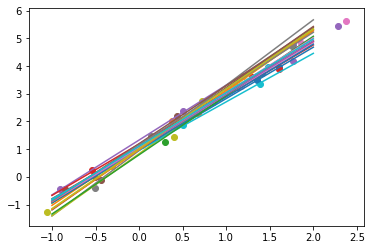

In [420]:
np.random.seed(4)
# ng
for i in range(ng):
    
    tmp = get_segments(x_train, gid_train, i)
    ytmp = get_segments(y_train, gid_train, i)
    plt.scatter(tmp, ytmp)
    plt.plot(np.linspace(-1,2,5), np.linspace(-1,2,5)* model.weights[0][i,0] + model.weights[6][i,0])

tf.Tensor(1.8540583, shape=(), dtype=float32)


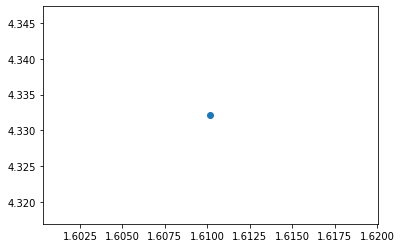

In [421]:
print(model.weights[0][0,0])
tmp = get_segments(x_train, gid_train, 0)
plt.scatter(tmp,tmp*0.2+4.+0.2*np.random.randn(len(tmp))[...,tf.newaxis])

In [1300]:
%tensorboard --logdir=../experiments/reg/ 

Reusing TensorBoard on port 6008 (pid 61760), started 1 day, 22:13:30 ago. (Use '!kill 61760' to kill it.)